In [1]:
import scipy
import utils.preprocess as preprocess
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import solvers.pdas as pdas
import solvers.ipm as ipm
from timeit import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

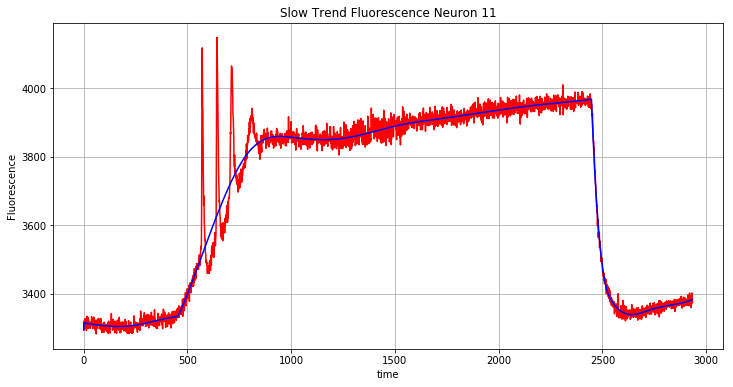

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

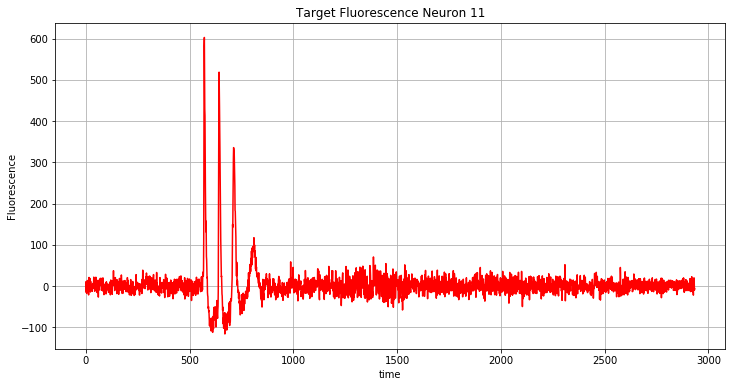

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal, 'r')
#ax.plot(np.arange(T), trend_filtered, 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Test Combined Implementation

In [7]:
idx = np.random.randint(0, N)
y = signals[idx,:].copy()

In [8]:
x_hat, z_hat = pdas.solve(y, 500, 1000, 1)

In [9]:
x_hat, z_hat = pdas.warm_start(y, 500, z_hat, 1000, 1)

In [10]:
x_hat_full, z_hat = ipm.solve(y, 500, False, 1e-4, 200, 1)

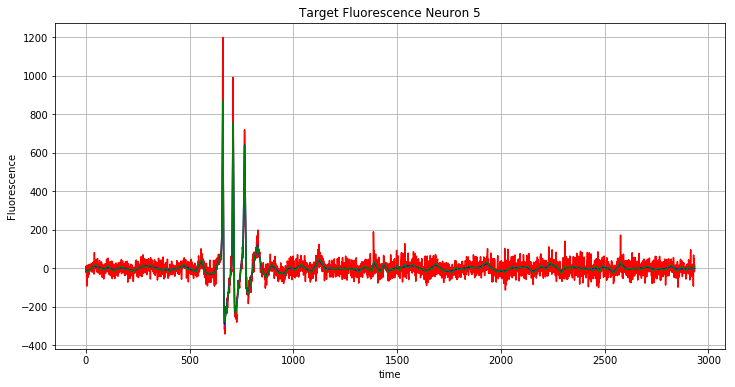

In [11]:
x_hat, z_hat = ipm.solve(y, 500, False, 1e6, 200, 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), y, 'r')
ax.plot(np.arange(T), np.array(x_hat_full), 'b')
ax.plot(np.arange(T), np.array(x_hat), 'g')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [12]:
def time_ipm():
    x_hat, z_hat = ipm.solve(y, 500, False, 1e-4, 200, 1)
def time_pdas():
    x_hat, _ = pdas.solve(y, 500, 1000, 1)

In [13]:
timeit(time_ipm, number=10)/10

0.011458182334899902

In [14]:
timeit(time_pdas, number=10)/10

0.013035893440246582

In [15]:
x_hat, z_hat = ipm.solve(y, 500, False, 1e2, 200, 1)
x_hat_ipm = np.array(x_hat)
z_hat_ipm = -1 * np.array(z_hat) / 500

In [16]:
idx = np.abs(np.abs(z_hat_ipm) - 1) < 1e-2

In [17]:
z_hat_ipm[idx] = np.sign(z_hat_ipm[idx])

In [61]:
x_hat, _ = pdas.warm_start(y, 500, z_hat_ipm, 1000, 1)

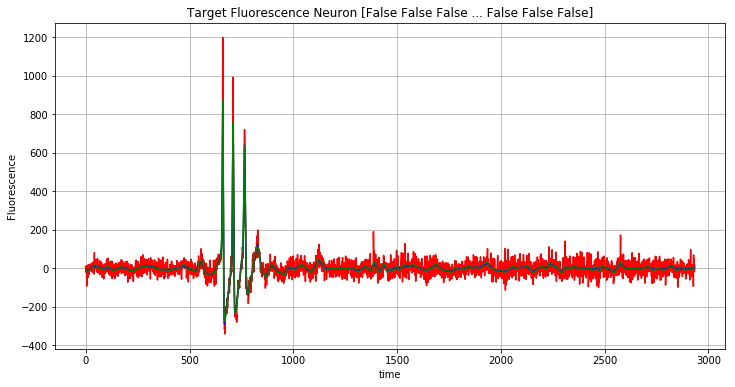

In [19]:
x_hat, z_hat = ipm.solve(y, 500, False, 1e6, 200, 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), y, 'r')
ax.plot(np.arange(T), np.array(x_hat_full), 'b')
ax.plot(np.arange(T), np.array(x_hat), 'g')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Warm Start Comparison

In [88]:
idx = np.random.randint(0, N)
signal = signals[idx,:]

In [89]:
ipm_times = np.zeros(30)
pdas_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _ = ipm.solve(target, lam, False, 1e-4, 200, 0)
    def time_pdas():
        _, _ = pdas.solve(target, lam, 1000, 1)
    ipm_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_times[ndx-1] += timeit(time_pdas, number=3)/3

In [90]:
ipm_tol_times = np.zeros(30)
pdas_ws_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _ = ipm.solve(target, lam, False, 1e2*ndx, 200, 0)
    _, z_hat = ipm.solve(target, lam, False, 1e2*ndx, 200, 1)
    warm_start = -1 * np.array(z_hat) / lam
    idx = np.abs(np.abs(warm_start) - 1) < 3e-2
    warm_start[idx] = np.sign(warm_start[idx])
    def time_pdas():
        _, _ = pdas.warm_start(target, lam, warm_start, 1000, 1)
    ipm_tol_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_ws_times[ndx-1] += timeit(time_pdas, number=1)/1

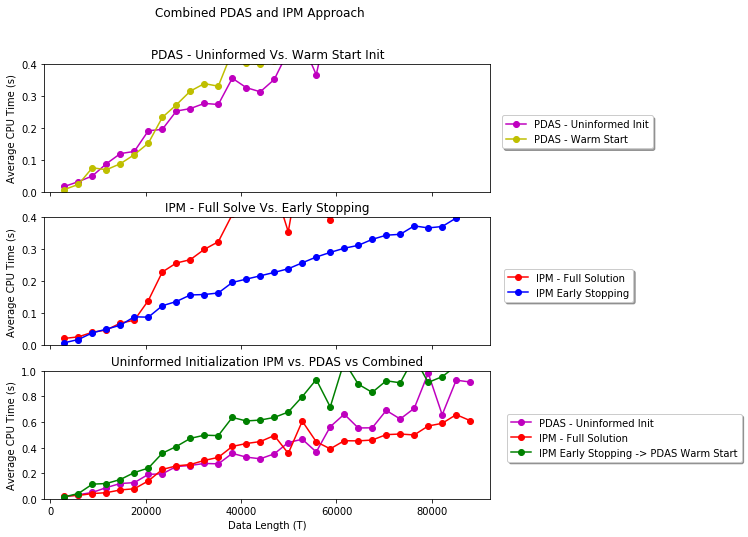

In [91]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, pdas_ws_times, marker='o', c='y')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('PDAS - Uninformed Vs. Warm Start Init')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Uninformed Init',
           'PDAS - Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.195, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times, marker='o', c='b')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('IPM - Full Solve Vs. Early Stopping')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['IPM - Full Solution',
           'IPM Early Stopping'], 
          loc='lower center', 
          bbox_to_anchor=(1.175, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times + pdas_ws_times, marker='o', c='g')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Uninformed Initialization IPM vs. PDAS vs Combined')
ax.locator_params(nbins=6)

fig.suptitle('Combined PDAS and IPM Approach')
ax.legend(['PDAS - Uninformed Init',
           'IPM - Full Solution',
           'IPM Early Stopping -> PDAS Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.3, .25),
          ncol=1,
          fancybox=True,
          shadow=True)
#fig.tight_layout()
plt.show()

In [92]:
def time_pdas_long():
    _, _ = pdas.solve(np.tile(signal, 500), 500, 1000, 1)

In [93]:
def time_ipm_long():
    _,_ = ipm.solve(np.tile(signal, 500), 500, False, 1e-4, 200, 1)

In [94]:
timeit(time_ipm_long, number=1)

13.034218072891235

# Constrained Problem

In [96]:
import utils.noise

In [ ]:
utils.n